#Translator
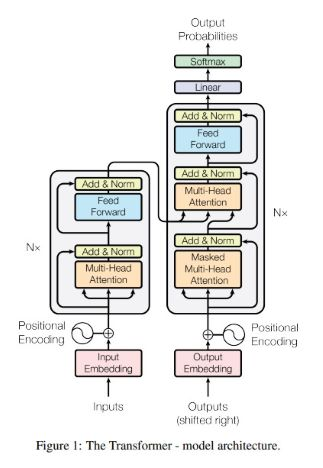

###Uploading data

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#check if GPU is available
import tensorflow as tf
import torch
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
######################## 1. CONFIGURATION #####################################
DATA_ZIP    = "/content/drive/MyDrive/MachineLearning/kor-eng.zip"   # copy path!
WORK_DIR    = "/content/drive/MyDrive/MachineLearning/kor-eng"                                      # everything created here
VOCAB_SIZE  = 8000                                                    # per language
BATCH_SIZE  = 64                                                      # GPU memory permitting
EPOCHS      = 5                                                       # increase later
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
################################################################################

In [ ]:
# 2. CLEAN START ──────────────────────────────
import os, shutil, zipfile, torch, math, sentencepiece as spm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

if os.path.isdir(WORK_DIR):
    shutil.rmtree(WORK_DIR)                                    # remove a previous directory
os.makedirs(WORK_DIR, exist_ok=True)                           # create a new directory

# 3. UNZIP THE DATA ─────────────────────────────
with zipfile.ZipFile(DATA_ZIP, "r") as z:                      # unzip the data
    z.extractall(WORK_DIR)

### Before running a code, check what data are in the file...

In [ ]:
# 4. SPLIT kor.txt → train.ko / train.en
SRC_PATH = f"{WORK_DIR}/train_ko.txt"
TGT_PATH = f"{WORK_DIR}/train_en.txt"

with open(f"{WORK_DIR}/kor.txt", encoding="utf-8") as f_in, \
     open(SRC_PATH, "w", encoding="utf-8") as f_ko, \
     open(TGT_PATH, "w", encoding="utf-8") as f_en:
    for line in f_in:
        parts = line.rstrip("\n").split("\t")
        if len(parts) < 2:
            continue
        en, ko = parts[0].lower(), parts[1].lower()
        f_en.write(en + "\n")
        f_ko.write(ko + "\n")

###Tokenization
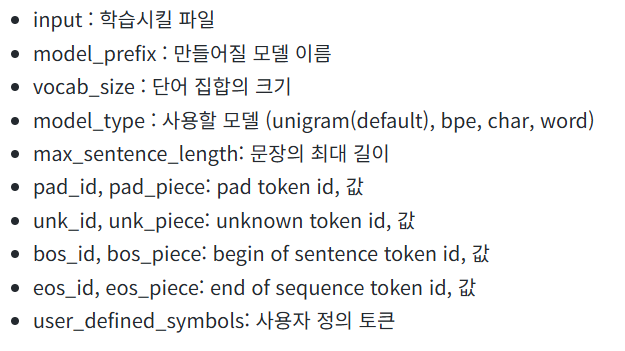

In [ ]:
# 5. TRAIN SENTENCEPIECE (PAD=0,BOS=2,EOS=3) ───────────────────────────────────
def train_spm(input_file, model_prefix, vocab_size, coverage):
    spm.SentencePieceTrainer.Train(
        f"--input={input_file} "
        f"--model_prefix={model_prefix} "
        f"--vocab_size={vocab_size} "
        f"--model_type=bpe "
        f"--character_coverage={coverage} "
        f"--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3"
    )

#Make a model
train_spm(SRC_PATH, f"{WORK_DIR}/spm_ko", VOCAB_SIZE, 0.9995)
train_spm(TGT_PATH, f"{WORK_DIR}/spm_en", VOCAB_SIZE, 1.0)

sp_ko = spm.SentencePieceProcessor(model_file=f"{WORK_DIR}/spm_ko.model")
sp_en = spm.SentencePieceProcessor(model_file=f"{WORK_DIR}/spm_en.model")

PAD_KO = sp_ko.pad_id()  # =0
PAD_EN = sp_en.pad_id()  # =0

In [ ]:
ids   = sp_ko.encode("안녕하세요", out_type=int)
text  = sp_ko.decode(ids)
print("Encoding '안녕하세요':",ids,f"\nDecoding {ids}:",text)

Encoding '안녕하세요': [1023, 692] 
Decoding [1023, 692]: 안녕하세요


In [ ]:
sp_en.bos_id()

2

In [ ]:
# 6. DATASET & DATALOADER ──────────────────────────────────────────────────────
class KoEnDataset(Dataset):
    def __init__(self, ko_path, en_path):
        self.ko = [l.strip() for l in open(ko_path, encoding="utf-8")]
        self.en = [l.strip() for l in open(en_path, encoding="utf-8")]

    def __len__(self): return len(self.ko)

    def __getitem__(self, idx):
        src_ids = [sp_ko.bos_id()] + sp_ko.EncodeAsIds(self.ko[idx]) + [sp_ko.eos_id()]
        tgt_ids = [sp_en.bos_id()] + sp_en.EncodeAsIds(self.en[idx]) + [sp_en.eos_id()]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate(batch):
    src, tgt = zip(*batch)
    src = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=PAD_KO)
    tgt = nn.utils.rnn.pad_sequence(tgt, batch_first=True, padding_value=PAD_EN)
    return src, tgt

train_loader = DataLoader(
    KoEnDataset(SRC_PATH, TGT_PATH),
    batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)


In [ ]:
KED=KoEnDataset(SRC_PATH, TGT_PATH)
KED.__getitem__(0)

(tensor([   2,   18, 7047,    3]), tensor([   2,   91, 7962,    3]))

In [ ]:
# 7. TRANSFORMER MODEL ─────────────────────────────────────────────────────────
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vs, vt, d_model=512, nhead=8,
                 nlayers=4, ff=2048, dropout=0.1):
        super().__init__()
        self.src_emb = nn.Embedding(vs, d_model)
        self.tgt_emb = nn.Embedding(vt, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model, nhead, nlayers, nlayers, ff, dropout, batch_first=True)
        self.generator = nn.Linear(d_model, vt)

    def forward(self, src, tgt):
        src_key_pad = (src == PAD_KO)
        tgt_key_pad = (tgt == PAD_EN)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt.size(1), device=tgt.device)
        src_emb = self.pos_enc(self.src_emb(src))
        tgt_emb = self.pos_enc(self.tgt_emb(tgt))
        out = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=src_key_pad,
            tgt_key_padding_mask=tgt_key_pad,
            memory_key_padding_mask=src_key_pad,
            tgt_mask=tgt_mask
        )
        return self.generator(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) *
                        (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos*div)
        pe[:, 1::2] = torch.cos(pos*div)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])

model = Seq2SeqTransformer(len(sp_ko), len(sp_en)).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_EN)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# 8. TRAINING LOOP ────────────────────────────────────────────────────────────
for epoch in range(1, EPOCHS+1):
    model.train(); epoch_loss = 0
    for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch}"):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_in, tgt_out = tgt[:, :-1], tgt[:, 1:]
        logits = model(src, tgt_in)
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1))
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch} – average loss {epoch_loss/len(train_loader):.4f}")

# 9. SIMPLE INFERENCE FUNCTION ────────────────────────────────────────────────
@torch.no_grad()
def translate(sentence_ko, max_len=60):
    model.eval()
    src_ids = [sp_ko.bos_id()] + sp_ko.EncodeAsIds(sentence_ko.lower()) + [sp_ko.eos_id()]
    src = torch.tensor(src_ids).unsqueeze(0).to(DEVICE)
    src_mask = (src == PAD_KO)
    memory = model.transformer.encoder(
        model.pos_enc(model.src_emb(src)),
        src_key_padding_mask=src_mask)
    ys = torch.tensor([[sp_en.bos_id()]], device=DEVICE)
    for _ in range(max_len):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            ys.size(1), device=DEVICE)
        out = model.transformer.decoder(
            model.pos_enc(model.tgt_emb(ys)),
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=src_mask)
        next_token = model.generator(out[:, -1]).argmax(-1).item()
        ys = torch.cat([ys, torch.tensor([[next_token]], device=DEVICE)], dim=1)
        if next_token == sp_en.eos_id():
            break
    return sp_en.DecodeIds(ys.squeeze().tolist())

print("▶", translate("안녕하세요"))
print("▶", translate("오늘 날씨가 좋네요"))


Epoch 1: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 1 – average loss 5.4680


Epoch 2: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 2 – average loss 4.1566


Epoch 3: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 3 – average loss 3.7631


Epoch 4: 100%|██████████| 93/93 [00:10<00:00,  9.19it/s]


Epoch 4 – average loss 3.4758


Epoch 5: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 5 – average loss 3.2485


Epoch 6: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 6 – average loss 3.0441


Epoch 7: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 7 – average loss 2.8845


Epoch 8: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 8 – average loss 2.6989


Epoch 9: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 9 – average loss 2.5111


Epoch 10: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 10 – average loss 2.3520


Epoch 11: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 11 – average loss 2.1967


Epoch 12: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 12 – average loss 2.0456


Epoch 13: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 13 – average loss 1.9097


Epoch 14: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 14 – average loss 1.7708


Epoch 15: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 15 – average loss 1.6408


Epoch 16: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 16 – average loss 1.5344


Epoch 17: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 17 – average loss 1.4061


Epoch 18: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 18 – average loss 1.3021


Epoch 19: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 19 – average loss 1.1937


Epoch 20: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 20 – average loss 1.1086


Epoch 21: 100%|██████████| 93/93 [00:09<00:00,  9.84it/s]


Epoch 21 – average loss 1.0082


Epoch 22: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 22 – average loss 0.9005


Epoch 23: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 23 – average loss 0.8131


Epoch 24: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 24 – average loss 0.7385


Epoch 25: 100%|██████████| 93/93 [00:09<00:00,  9.95it/s]


Epoch 25 – average loss 0.6708


Epoch 26: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 26 – average loss 0.6059


Epoch 27: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 27 – average loss 0.5489


Epoch 28: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 28 – average loss 0.4868


Epoch 29: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 29 – average loss 0.4214


Epoch 30: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 30 – average loss 0.3769


Epoch 31: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 31 – average loss 0.3440


Epoch 32: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 32 – average loss 0.3262


Epoch 33: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 33 – average loss 0.2761


Epoch 34: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 34 – average loss 0.2609


Epoch 35: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 35 – average loss 0.2345


Epoch 36: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 36 – average loss 0.2269


Epoch 37: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 37 – average loss 0.1855


Epoch 38: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 38 – average loss 0.1670


Epoch 39: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 39 – average loss 0.1519


Epoch 40: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 40 – average loss 0.1399


Epoch 41: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 41 – average loss 0.1363


Epoch 42: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 42 – average loss 0.1256


Epoch 43: 100%|██████████| 93/93 [00:09<00:00,  9.62it/s]


Epoch 43 – average loss 0.1258


Epoch 44: 100%|██████████| 93/93 [00:09<00:00,  9.59it/s]


Epoch 44 – average loss 0.1209


Epoch 45: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 45 – average loss 0.1069


Epoch 46: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 46 – average loss 0.1098


Epoch 47: 100%|██████████| 93/93 [00:09<00:00,  9.82it/s]


Epoch 47 – average loss 0.0996


Epoch 48: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 48 – average loss 0.0931


Epoch 49: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 49 – average loss 0.0880


Epoch 50: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 50 – average loss 0.0880


Epoch 51: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 51 – average loss 0.0867


Epoch 52: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 52 – average loss 0.0773


Epoch 53: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 53 – average loss 0.0796


Epoch 54: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 54 – average loss 0.0731


Epoch 55: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 55 – average loss 0.0709


Epoch 56: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 56 – average loss 0.0768


Epoch 57: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 57 – average loss 0.0692


Epoch 58: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 58 – average loss 0.0672


Epoch 59: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 59 – average loss 0.0660


Epoch 60: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 60 – average loss 0.0831


Epoch 61: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 61 – average loss 0.0768


Epoch 62: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 62 – average loss 0.0746


Epoch 63: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 63 – average loss 0.0764


Epoch 64: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 64 – average loss 0.0657


Epoch 65: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 65 – average loss 0.0603


Epoch 66: 100%|██████████| 93/93 [00:09<00:00,  9.86it/s]


Epoch 66 – average loss 0.0746


Epoch 67: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 67 – average loss 0.0654


Epoch 68: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 68 – average loss 0.0612


Epoch 69: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 69 – average loss 0.0652


Epoch 70: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 70 – average loss 0.0531


Epoch 71: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 71 – average loss 0.0551


Epoch 72: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 72 – average loss 0.0566


Epoch 73: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 73 – average loss 0.0638


Epoch 74: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 74 – average loss 0.0566


Epoch 75: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 75 – average loss 0.0556


Epoch 76: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 76 – average loss 0.0474


Epoch 77: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 77 – average loss 0.0458


Epoch 78: 100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


Epoch 78 – average loss 0.0503


Epoch 79: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 79 – average loss 0.0524


Epoch 80: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 80 – average loss 0.0490


Epoch 81: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 81 – average loss 0.0474


Epoch 82: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 82 – average loss 0.0554


Epoch 83: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 83 – average loss 0.0443


Epoch 84: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 84 – average loss 0.0500


Epoch 85: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 85 – average loss 0.0423


Epoch 86: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 86 – average loss 0.0376


Epoch 87: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 87 – average loss 0.0370


Epoch 88: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 88 – average loss 0.0368


Epoch 89: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 89 – average loss 0.0377


Epoch 90: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 90 – average loss 0.0419


Epoch 91: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 91 – average loss 0.0404


Epoch 92: 100%|██████████| 93/93 [00:09<00:00,  9.93it/s]


Epoch 92 – average loss 0.0381


Epoch 93: 100%|██████████| 93/93 [00:09<00:00,  9.82it/s]


Epoch 93 – average loss 0.0380


Epoch 94: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 94 – average loss 0.0409


Epoch 95: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 95 – average loss 0.0379


Epoch 96: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 96 – average loss 0.0371


Epoch 97: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 97 – average loss 0.0421


Epoch 98: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 98 – average loss 0.0407


Epoch 99: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 99 – average loss 0.0371


Epoch 100: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 100 – average loss 0.0395


Epoch 101: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 101 – average loss 0.0401


Epoch 102: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 102 – average loss 0.0371


Epoch 103: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 103 – average loss 0.0450


Epoch 104: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 104 – average loss 0.0353


Epoch 105: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 105 – average loss 0.0339


Epoch 106: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 106 – average loss 0.0423


Epoch 107: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 107 – average loss 0.0473


Epoch 108: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 108 – average loss 0.0399


Epoch 109: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 109 – average loss 0.0388


Epoch 110: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 110 – average loss 0.0388


Epoch 111: 100%|██████████| 93/93 [00:09<00:00,  9.87it/s]


Epoch 111 – average loss 0.0456


Epoch 112: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 112 – average loss 0.0360


Epoch 113: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 113 – average loss 0.0380


Epoch 114: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 114 – average loss 0.0329


Epoch 115: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 115 – average loss 0.0326


Epoch 116: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 116 – average loss 0.0420


Epoch 117: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 117 – average loss 0.0320


Epoch 118: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 118 – average loss 0.0299


Epoch 119: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 119 – average loss 0.0297


Epoch 120: 100%|██████████| 93/93 [00:09<00:00,  9.60it/s]


Epoch 120 – average loss 0.0375


Epoch 121: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 121 – average loss 0.0416


Epoch 122: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 122 – average loss 0.0323


Epoch 123: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 123 – average loss 0.0370


Epoch 124: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 124 – average loss 0.0390


Epoch 125: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 125 – average loss 0.0319


Epoch 126: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 126 – average loss 0.0322


Epoch 127: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 127 – average loss 0.0314


Epoch 128: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 128 – average loss 0.0319


Epoch 129: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 129 – average loss 0.0353


Epoch 130: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 130 – average loss 0.0330


Epoch 131: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 131 – average loss 0.0317


Epoch 132: 100%|██████████| 93/93 [00:09<00:00,  9.88it/s]


Epoch 132 – average loss 0.0282


Epoch 133: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 133 – average loss 0.0268


Epoch 134: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 134 – average loss 0.0264


Epoch 135: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 135 – average loss 0.0263


Epoch 136: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 136 – average loss 0.0252


Epoch 137: 100%|██████████| 93/93 [00:09<00:00,  9.93it/s]


Epoch 137 – average loss 0.0249


Epoch 138: 100%|██████████| 93/93 [00:09<00:00,  9.82it/s]


Epoch 138 – average loss 0.0258


Epoch 139: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 139 – average loss 0.0266


Epoch 140: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 140 – average loss 0.0270


Epoch 141: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 141 – average loss 0.0259


Epoch 142: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 142 – average loss 0.0249


Epoch 143: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 143 – average loss 0.0233


Epoch 144: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 144 – average loss 0.0257


Epoch 145: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 145 – average loss 0.0264


Epoch 146: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 146 – average loss 0.0392


Epoch 147: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 147 – average loss 0.0349


Epoch 148: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 148 – average loss 0.0307


Epoch 149: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 149 – average loss 0.0262


Epoch 150: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 150 – average loss 0.0313


Epoch 151: 100%|██████████| 93/93 [00:09<00:00,  9.84it/s]


Epoch 151 – average loss 0.0297


Epoch 152: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 152 – average loss 0.0257


Epoch 153: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 153 – average loss 0.0238


Epoch 154: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 154 – average loss 0.0259


Epoch 155: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 155 – average loss 0.0247


Epoch 156: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 156 – average loss 0.0262


Epoch 157: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 157 – average loss 0.0269


Epoch 158: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 158 – average loss 0.0271


Epoch 159: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 159 – average loss 0.0287


Epoch 160: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 160 – average loss 0.0291


Epoch 161: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 161 – average loss 0.0255


Epoch 162: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 162 – average loss 0.0265


Epoch 163: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 163 – average loss 0.0312


Epoch 164: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 164 – average loss 0.0253


Epoch 165: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 165 – average loss 0.0233


Epoch 166: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 166 – average loss 0.0231


Epoch 167: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 167 – average loss 0.0242


Epoch 168: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 168 – average loss 0.0313


Epoch 169: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 169 – average loss 0.0283


Epoch 170: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 170 – average loss 0.0349


Epoch 171: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 171 – average loss 0.0289


Epoch 172: 100%|██████████| 93/93 [00:09<00:00,  9.86it/s]


Epoch 172 – average loss 0.0274


Epoch 173: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 173 – average loss 0.0232


Epoch 174: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 174 – average loss 0.0217


Epoch 175: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 175 – average loss 0.0206


Epoch 176: 100%|██████████| 93/93 [00:09<00:00,  9.61it/s]


Epoch 176 – average loss 0.0213


Epoch 177: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 177 – average loss 0.0204


Epoch 178: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 178 – average loss 0.0192


Epoch 179: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 179 – average loss 0.0189


Epoch 180: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 180 – average loss 0.0202


Epoch 181: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 181 – average loss 0.0199


Epoch 182: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 182 – average loss 0.0226


Epoch 183: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 183 – average loss 0.0253


Epoch 184: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 184 – average loss 0.0241


Epoch 185: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 185 – average loss 0.0225


Epoch 186: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 186 – average loss 0.0229


Epoch 187: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 187 – average loss 0.0252


Epoch 188: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 188 – average loss 0.0270


Epoch 189: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 189 – average loss 0.0264


Epoch 190: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 190 – average loss 0.0247


Epoch 191: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 191 – average loss 0.0235


Epoch 192: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 192 – average loss 0.0231


Epoch 193: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 193 – average loss 0.0255


Epoch 194: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 194 – average loss 0.0269


Epoch 195: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 195 – average loss 0.0223


Epoch 196: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 196 – average loss 0.0232


Epoch 197: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 197 – average loss 0.0223


Epoch 198: 100%|██████████| 93/93 [00:09<00:00,  9.61it/s]


Epoch 198 – average loss 0.0233


Epoch 199: 100%|██████████| 93/93 [00:09<00:00,  9.56it/s]


Epoch 199 – average loss 0.0218


Epoch 200: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 200 – average loss 0.0198


Epoch 201: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 201 – average loss 0.0211


Epoch 202: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 202 – average loss 0.0203


Epoch 203: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 203 – average loss 0.0220


Epoch 204: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 204 – average loss 0.0198


Epoch 205: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 205 – average loss 0.0185


Epoch 206: 100%|██████████| 93/93 [00:09<00:00,  9.62it/s]


Epoch 206 – average loss 0.0192


Epoch 207: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 207 – average loss 0.0230


Epoch 208: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 208 – average loss 0.0284


Epoch 209: 100%|██████████| 93/93 [00:09<00:00,  9.62it/s]


Epoch 209 – average loss 0.0283


Epoch 210: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 210 – average loss 0.0242


Epoch 211: 100%|██████████| 93/93 [00:09<00:00,  9.59it/s]


Epoch 211 – average loss 0.0234


Epoch 212: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 212 – average loss 0.0225


Epoch 213: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 213 – average loss 0.0195


Epoch 214: 100%|██████████| 93/93 [00:09<00:00,  9.62it/s]


Epoch 214 – average loss 0.0198


Epoch 215: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 215 – average loss 0.0181


Epoch 216: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 216 – average loss 0.0193


Epoch 217: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 217 – average loss 0.0186


Epoch 218: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 218 – average loss 0.0180


Epoch 219: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 219 – average loss 0.0212


Epoch 220: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 220 – average loss 0.0267


Epoch 221: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 221 – average loss 0.0224


Epoch 222: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 222 – average loss 0.0256


Epoch 223: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 223 – average loss 0.0202


Epoch 224: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 224 – average loss 0.0197


Epoch 225: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 225 – average loss 0.0245


Epoch 226: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 226 – average loss 0.0262


Epoch 227: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 227 – average loss 0.0219


Epoch 228: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 228 – average loss 0.0187


Epoch 229: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 229 – average loss 0.0180


Epoch 230: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 230 – average loss 0.0172


Epoch 231: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 231 – average loss 0.0173


Epoch 232: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 232 – average loss 0.0169


Epoch 233: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 233 – average loss 0.0164


Epoch 234: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 234 – average loss 0.0164


Epoch 235: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 235 – average loss 0.0178


Epoch 236: 100%|██████████| 93/93 [00:09<00:00,  9.60it/s]


Epoch 236 – average loss 0.0172


Epoch 237: 100%|██████████| 93/93 [00:09<00:00,  9.60it/s]


Epoch 237 – average loss 0.0192


Epoch 238: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 238 – average loss 0.0207


Epoch 239: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 239 – average loss 0.0202


Epoch 240: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 240 – average loss 0.0235


Epoch 241: 100%|██████████| 93/93 [00:09<00:00,  9.87it/s]


Epoch 241 – average loss 0.0241


Epoch 242: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 242 – average loss 0.0226


Epoch 243: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 243 – average loss 0.0217


Epoch 244: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 244 – average loss 0.0212


Epoch 245: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 245 – average loss 0.0232


Epoch 246: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 246 – average loss 0.0218


Epoch 247: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 247 – average loss 0.0214


Epoch 248: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 248 – average loss 0.0192


Epoch 249: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 249 – average loss 0.0211


Epoch 250: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 250 – average loss 0.0202


Epoch 251: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 251 – average loss 0.0193


Epoch 252: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 252 – average loss 0.0235


Epoch 253: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 253 – average loss 0.0197


Epoch 254: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 254 – average loss 0.0170


Epoch 255: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 255 – average loss 0.0177


Epoch 256: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 256 – average loss 0.0233


Epoch 257: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 257 – average loss 0.0194


Epoch 258: 100%|██████████| 93/93 [00:09<00:00,  9.61it/s]


Epoch 258 – average loss 0.0293


Epoch 259: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 259 – average loss 0.0226


Epoch 260: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 260 – average loss 0.0281


Epoch 261: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 261 – average loss 0.0182


Epoch 262: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 262 – average loss 0.0170


Epoch 263: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 263 – average loss 0.0162


Epoch 264: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 264 – average loss 0.0156


Epoch 265: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 265 – average loss 0.0153


Epoch 266: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 266 – average loss 0.0162


Epoch 267: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 267 – average loss 0.0179


Epoch 268: 100%|██████████| 93/93 [00:09<00:00,  9.88it/s]


Epoch 268 – average loss 0.0180


Epoch 269: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 269 – average loss 0.0165


Epoch 270: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 270 – average loss 0.0173


Epoch 271: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 271 – average loss 0.0154


Epoch 272: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 272 – average loss 0.0170


Epoch 273: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 273 – average loss 0.0192


Epoch 274: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 274 – average loss 0.0188


Epoch 275: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 275 – average loss 0.0208


Epoch 276: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 276 – average loss 0.0189


Epoch 277: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 277 – average loss 0.0158


Epoch 278: 100%|██████████| 93/93 [00:09<00:00,  9.61it/s]


Epoch 278 – average loss 0.0183


Epoch 279: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 279 – average loss 0.0193


Epoch 280: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 280 – average loss 0.0193


Epoch 281: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 281 – average loss 0.0232


Epoch 282: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 282 – average loss 0.0196


Epoch 283: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 283 – average loss 0.0202


Epoch 284: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 284 – average loss 0.0178


Epoch 285: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 285 – average loss 0.0174


Epoch 286: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 286 – average loss 0.0181


Epoch 287: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 287 – average loss 0.0176


Epoch 288: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 288 – average loss 0.0173


Epoch 289: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 289 – average loss 0.0166


Epoch 290: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 290 – average loss 0.0158


Epoch 291: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 291 – average loss 0.0157


Epoch 292: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 292 – average loss 0.0149


Epoch 293: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 293 – average loss 0.0155


Epoch 294: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 294 – average loss 0.0167


Epoch 295: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 295 – average loss 0.0169


Epoch 296: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 296 – average loss 0.0166


Epoch 297: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 297 – average loss 0.0196


Epoch 298: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 298 – average loss 0.0186


Epoch 299: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 299 – average loss 0.0203


Epoch 300: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 300 – average loss 0.0207


Epoch 301: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 301 – average loss 0.0271


Epoch 302: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 302 – average loss 0.0209


Epoch 303: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 303 – average loss 0.0191


Epoch 304: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 304 – average loss 0.0206


Epoch 305: 100%|██████████| 93/93 [00:09<00:00,  9.88it/s]


Epoch 305 – average loss 0.0185


Epoch 306: 100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


Epoch 306 – average loss 0.0197


Epoch 307: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 307 – average loss 0.0168


Epoch 308: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 308 – average loss 0.0169


Epoch 309: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 309 – average loss 0.0162


Epoch 310: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 310 – average loss 0.0168


Epoch 311: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 311 – average loss 0.0156


Epoch 312: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 312 – average loss 0.0145


Epoch 313: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 313 – average loss 0.0147


Epoch 314: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 314 – average loss 0.0148


Epoch 315: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 315 – average loss 0.0142


Epoch 316: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 316 – average loss 0.0154


Epoch 317: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 317 – average loss 0.0164


Epoch 318: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 318 – average loss 0.0148


Epoch 319: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 319 – average loss 0.0166


Epoch 320: 100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


Epoch 320 – average loss 0.0165


Epoch 321: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 321 – average loss 0.0181


Epoch 322: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 322 – average loss 0.0183


Epoch 323: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 323 – average loss 0.0176


Epoch 324: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 324 – average loss 0.0184


Epoch 325: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 325 – average loss 0.0204


Epoch 326: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 326 – average loss 0.0247


Epoch 327: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 327 – average loss 0.0220


Epoch 328: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 328 – average loss 0.0186


Epoch 329: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 329 – average loss 0.0153


Epoch 330: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 330 – average loss 0.0150


Epoch 331: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 331 – average loss 0.0168


Epoch 332: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 332 – average loss 0.0162


Epoch 333: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 333 – average loss 0.0161


Epoch 334: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 334 – average loss 0.0166


Epoch 335: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 335 – average loss 0.0168


Epoch 336: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 336 – average loss 0.0171


Epoch 337: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 337 – average loss 0.0145


Epoch 338: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 338 – average loss 0.0143


Epoch 339: 100%|██████████| 93/93 [00:09<00:00,  9.89it/s]


Epoch 339 – average loss 0.0148


Epoch 340: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 340 – average loss 0.0147


Epoch 341: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 341 – average loss 0.0139


Epoch 342: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 342 – average loss 0.0167


Epoch 343: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 343 – average loss 0.0209


Epoch 344: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 344 – average loss 0.0223


Epoch 345: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 345 – average loss 0.0190


Epoch 346: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 346 – average loss 0.0186


Epoch 347: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 347 – average loss 0.0177


Epoch 348: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 348 – average loss 0.0201


Epoch 349: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 349 – average loss 0.0182


Epoch 350: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 350 – average loss 0.0161


Epoch 351: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 351 – average loss 0.0148


Epoch 352: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 352 – average loss 0.0175


Epoch 353: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 353 – average loss 0.0146


Epoch 354: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 354 – average loss 0.0152


Epoch 355: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 355 – average loss 0.0157


Epoch 356: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 356 – average loss 0.0156


Epoch 357: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 357 – average loss 0.0153


Epoch 358: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 358 – average loss 0.0151


Epoch 359: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 359 – average loss 0.0163


Epoch 360: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 360 – average loss 0.0158


Epoch 361: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 361 – average loss 0.0172


Epoch 362: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 362 – average loss 0.0168


Epoch 363: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 363 – average loss 0.0174


Epoch 364: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 364 – average loss 0.0178


Epoch 365: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 365 – average loss 0.0176


Epoch 366: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 366 – average loss 0.0167


Epoch 367: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 367 – average loss 0.0155


Epoch 368: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 368 – average loss 0.0155


Epoch 369: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 369 – average loss 0.0160


Epoch 370: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 370 – average loss 0.0154


Epoch 371: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 371 – average loss 0.0161


Epoch 372: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 372 – average loss 0.0156


Epoch 373: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 373 – average loss 0.0165


Epoch 374: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 374 – average loss 0.0161


Epoch 375: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 375 – average loss 0.0168


Epoch 376: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 376 – average loss 0.0178


Epoch 377: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 377 – average loss 0.0210


Epoch 378: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 378 – average loss 0.0199


Epoch 379: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 379 – average loss 0.0170


Epoch 380: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 380 – average loss 0.0156


Epoch 381: 100%|██████████| 93/93 [00:09<00:00,  9.86it/s]


Epoch 381 – average loss 0.0143


Epoch 382: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 382 – average loss 0.0133


Epoch 383: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 383 – average loss 0.0137


Epoch 384: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 384 – average loss 0.0146


Epoch 385: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 385 – average loss 0.0148


Epoch 386: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 386 – average loss 0.0166


Epoch 387: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 387 – average loss 0.0180


Epoch 388: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 388 – average loss 0.0181


Epoch 389: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 389 – average loss 0.0161


Epoch 390: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 390 – average loss 0.0159


Epoch 391: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 391 – average loss 0.0165


Epoch 392: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 392 – average loss 0.0144


Epoch 393: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 393 – average loss 0.0172


Epoch 394: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 394 – average loss 0.0166


Epoch 395: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 395 – average loss 0.0205


Epoch 396: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 396 – average loss 0.0237


Epoch 397: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 397 – average loss 0.0190


Epoch 398: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 398 – average loss 0.0162


Epoch 399: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 399 – average loss 0.0152


Epoch 400: 100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


Epoch 400 – average loss 0.0149


Epoch 401: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 401 – average loss 0.0143


Epoch 402: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 402 – average loss 0.0138


Epoch 403: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 403 – average loss 0.0127


Epoch 404: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 404 – average loss 0.0125


Epoch 405: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 405 – average loss 0.0125


Epoch 406: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 406 – average loss 0.0137


Epoch 407: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 407 – average loss 0.0133


Epoch 408: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 408 – average loss 0.0137


Epoch 409: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 409 – average loss 0.0132


Epoch 410: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 410 – average loss 0.0142


Epoch 411: 100%|██████████| 93/93 [00:09<00:00,  9.84it/s]


Epoch 411 – average loss 0.0176


Epoch 412: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 412 – average loss 0.0162


Epoch 413: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 413 – average loss 0.0173


Epoch 414: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 414 – average loss 0.0167


Epoch 415: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 415 – average loss 0.0159


Epoch 416: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 416 – average loss 0.0158


Epoch 417: 100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


Epoch 417 – average loss 0.0158


Epoch 418: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 418 – average loss 0.0158


Epoch 419: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 419 – average loss 0.0149


Epoch 420: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 420 – average loss 0.0140


Epoch 421: 100%|██████████| 93/93 [00:09<00:00,  9.91it/s]


Epoch 421 – average loss 0.0135


Epoch 422: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 422 – average loss 0.0138


Epoch 423: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 423 – average loss 0.0163


Epoch 424: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 424 – average loss 0.0161


Epoch 425: 100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


Epoch 425 – average loss 0.0166


Epoch 426: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 426 – average loss 0.0159


Epoch 427: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 427 – average loss 0.0147


Epoch 428: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 428 – average loss 0.0152


Epoch 429: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 429 – average loss 0.0161


Epoch 430: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 430 – average loss 0.0197


Epoch 431: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 431 – average loss 0.0172


Epoch 432: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 432 – average loss 0.0162


Epoch 433: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 433 – average loss 0.0143


Epoch 434: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 434 – average loss 0.0146


Epoch 435: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 435 – average loss 0.0167


Epoch 436: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 436 – average loss 0.0170


Epoch 437: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 437 – average loss 0.0152


Epoch 438: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 438 – average loss 0.0148


Epoch 439: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 439 – average loss 0.0141


Epoch 440: 100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Epoch 440 – average loss 0.0127


Epoch 441: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 441 – average loss 0.0138


Epoch 442: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 442 – average loss 0.0139


Epoch 443: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 443 – average loss 0.0141


Epoch 444: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 444 – average loss 0.0142


Epoch 445: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 445 – average loss 0.0161


Epoch 446: 100%|██████████| 93/93 [00:09<00:00,  9.81it/s]


Epoch 446 – average loss 0.0156


Epoch 447: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 447 – average loss 0.0151


Epoch 448: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 448 – average loss 0.0163


Epoch 449: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 449 – average loss 0.0150


Epoch 450: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 450 – average loss 0.0153


Epoch 451: 100%|██████████| 93/93 [00:09<00:00,  9.83it/s]


Epoch 451 – average loss 0.0154


Epoch 452: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 452 – average loss 0.0159


Epoch 453: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 453 – average loss 0.0167


Epoch 454: 100%|██████████| 93/93 [00:09<00:00,  9.84it/s]


Epoch 454 – average loss 0.0141


Epoch 455: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 455 – average loss 0.0121


Epoch 456: 100%|██████████| 93/93 [00:09<00:00,  9.77it/s]


Epoch 456 – average loss 0.0131


Epoch 457: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 457 – average loss 0.0130


Epoch 458: 100%|██████████| 93/93 [00:09<00:00,  9.84it/s]


Epoch 458 – average loss 0.0123


Epoch 459: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 459 – average loss 0.0129


Epoch 460: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 460 – average loss 0.0148


Epoch 461: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 461 – average loss 0.0199


Epoch 462: 100%|██████████| 93/93 [00:09<00:00,  9.79it/s]


Epoch 462 – average loss 0.0159


Epoch 463: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 463 – average loss 0.0191


Epoch 464: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 464 – average loss 0.0147


Epoch 465: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 465 – average loss 0.0144


Epoch 466: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 466 – average loss 0.0151


Epoch 467: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 467 – average loss 0.0152


Epoch 468: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 468 – average loss 0.0152


Epoch 469: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 469 – average loss 0.0128


Epoch 470: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 470 – average loss 0.0128


Epoch 471: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 471 – average loss 0.0139


Epoch 472: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 472 – average loss 0.0135


Epoch 473: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 473 – average loss 0.0129


Epoch 474: 100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


Epoch 474 – average loss 0.0125


Epoch 475: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 475 – average loss 0.0134


Epoch 476: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 476 – average loss 0.0166


Epoch 477: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 477 – average loss 0.0150


Epoch 478: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 478 – average loss 0.0157


Epoch 479: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


Epoch 479 – average loss 0.0151


Epoch 480: 100%|██████████| 93/93 [00:09<00:00,  9.59it/s]


Epoch 480 – average loss 0.0147


Epoch 481: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 481 – average loss 0.0181


Epoch 482: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 482 – average loss 0.0206


Epoch 483: 100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


Epoch 483 – average loss 0.0148


Epoch 484: 100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch 484 – average loss 0.0146


Epoch 485: 100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


Epoch 485 – average loss 0.0173


Epoch 486: 100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


Epoch 486 – average loss 0.0146


Epoch 487: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 487 – average loss 0.0140


Epoch 488: 100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch 488 – average loss 0.0166


Epoch 489: 100%|██████████| 93/93 [00:09<00:00,  9.74it/s]


Epoch 489 – average loss 0.0132


Epoch 490: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 490 – average loss 0.0132


Epoch 491: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 491 – average loss 0.0128


Epoch 492: 100%|██████████| 93/93 [00:09<00:00,  9.76it/s]


Epoch 492 – average loss 0.0124


Epoch 493: 100%|██████████| 93/93 [00:09<00:00,  9.75it/s]


Epoch 493 – average loss 0.0132


Epoch 494: 100%|██████████| 93/93 [00:09<00:00,  9.66it/s]


Epoch 494 – average loss 0.0147


Epoch 495: 100%|██████████| 93/93 [00:09<00:00,  9.69it/s]


Epoch 495 – average loss 0.0158


Epoch 496: 100%|██████████| 93/93 [00:09<00:00,  9.86it/s]


Epoch 496 – average loss 0.0146


Epoch 497: 100%|██████████| 93/93 [00:09<00:00,  9.60it/s]


Epoch 497 – average loss 0.0146


Epoch 498: 100%|██████████| 93/93 [00:09<00:00,  9.78it/s]


Epoch 498 – average loss 0.0141


Epoch 499: 100%|██████████| 93/93 [00:09<00:00,  9.72it/s]


Epoch 499 – average loss 0.0137


Epoch 500: 100%|██████████| 93/93 [00:09<00:00,  9.73it/s]

Epoch 500 – average loss 0.0134
▶ good morning, everybody.
▶ the weather is good today.


In [ ]:
print("▶", translate("학교 가기 싫다."))

▶ go to school.


## Exercise
###Make a translator from English to Korean!